## Import librari

In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import os
import time
from IPython import display


# Download and read file entities

In [6]:
# dataset_url = "https://raw.githubusercontent.com/AndiAlifs/sistem_cerdas_chatbot_selma/master/entities.json"

In [7]:
# read json file
with open('entities.json') as f:
    data = json.load(f)

In [8]:
data

{'entities': {'seleksi_masuk': [{'tag': 'snmptn',
    'pattern': ['seleksi nasional',
     'snmptn',
     'jalur undangan',
     'jalur prestasi']},
   {'tag': 'sbmptn', 'pattern': ['seleksi bersama', 'sbmptn', 'utbk']},
   {'tag': 'afirmasi',
    'pattern': ['afirmasi', 'jalur khusus', 'jalur khusus lainnya']},
   {'tag': 'mandiri',
    'pattern': ['mandiri', 'jalur mandiri', 'jalur mandiri lainnya']},
   {'tag': 'reguler',
    'pattern': ['reguler', 'jalur reguler', 'jalur reguler lainnya']},
   {'tag': 'rapor', 'pattern': ['nilai rapor', 'jalur nilai rapor']},
   {'tag': 'utbk', 'pattern': ['nilai utbk', 'jalur nilai utbk']}],
  'fakultas': [{'tag': 'filkom',
    'pattern': ['fakultas ilmu komputer', 'filkom', 'ilmu komputer']},
   {'tag': 'fisip',
    'pattern': ['fakultas ilmu sosial dan ilmu politik',
     'fisip',
     'ilmu sosial dan ilmu politik',
     'sosial',
     'politik']},
   {'tag': 'fk', 'pattern': ['fk', 'kedokteran', 'fakultas kedokteran']},
   {'tag': 'fkh',
    '

# Splitting file entities

In [9]:
data_selksiMasuk = data['entities']['seleksi_masuk']
data_fakultas = data['entities']['fakultas']
data_prodi = data['entities']['prodi']

In [10]:
tag = []
patterns = []

for i in data_selksiMasuk:
    for pattern in i['pattern']:
        tag.append(i['tag'])
        patterns.append(pattern)

dfSeleksiMasuk = pd.DataFrame({'tag': tag, 'patterns': patterns})

In [11]:
tag = []
patterns = []

for i in data_fakultas:
    for pattern in i['pattern']:
        tag.append(i['tag'])
        patterns.append(pattern)

dfFakultas = pd.DataFrame({'tag': tag, 'patterns': patterns})

In [12]:
tag = []
patterns = []

for i in data_prodi:
    for pattern in i['pattern']:
        tag.append(i['tag'])
        patterns.append(pattern)

dfProdi = pd.DataFrame({'tag': tag, 'patterns': patterns})

In [13]:
# preprocessing data text
import re

def preprocessing_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text = text.strip()
    return text

In [14]:
#make callbacks when model accurcay hit 90%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.9):
            print("\nReached 90% accuracy so cancelling training!")
            self.model.stop_training = True

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


In [28]:
def get_feature_names(vectorizer):
    feature_names = vectorizer.get_feature_names()
    return feature_names

# Training entiti recognition for seleksimasuk

In [33]:
# training model for seleksiMasuk
vectorizerSlekMasuk = TfidfVectorizer()
X = vectorizerSlekMasuk.fit_transform(dfSeleksiMasuk['patterns'].apply(preprocessing_text))
X = X.toarray()
Y = dfSeleksiMasuk['tag'].values

classCount = len(np.unique(Y))

label_encoderSeleksiMasuk = LabelEncoder()
integer_encoded = label_encoderSeleksiMasuk.fit_transform(Y)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
Y = onehot_encoder.fit_transform(integer_encoded)

X_train = X
y_train = Y

take = 0.2
x_test = X_train[:int(len(X_train)*take)]
y_test = y_train[:int(len(y_train)*take)]

modelForSeleksiMasuk = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(classCount, activation='softmax'),
])

modelForSeleksiMasuk.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

callbacks = myCallback()

history = modelForSeleksiMasuk.fit(X_train, y_train,
                        validation_data=(x_test, y_test),epochs=100, callbacks=[callbacks])

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 1.9537 - accuracy: 0.0500 - val_loss: 1.9693 - val_accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 57ms/step - loss: 1.9390 - accuracy: 0.1500 - val_loss: 1.9532 - val_accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 100ms/step - loss: 1.9257 - accuracy: 0.1500 - val_loss: 1.9387 - val_accuracy: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 64ms/step - loss: 1.9131 - accuracy: 0.2500 - val_loss: 1.9262 - val_accuracy: 0.2500
Epoch 5/100
1/1 [==============================] - 0s 46ms/step - loss: 1.9018 - accuracy: 0.4000 - val_loss: 1.9123 - val_accuracy: 0.2500
Epoch 6/100
1/1 [==============================] - 0s 37ms/step - loss: 1.8912 - accuracy: 0.4500 - val_loss: 1.8974 - val_accuracy: 0.5000
Epoch 7/100
1/1 [==============================] - 0s 38ms/step - loss: 1.8801 - accuracy: 0.5000 - val_loss: 1.8825 - val_accuracy: 0.7500
Epoch 8/1

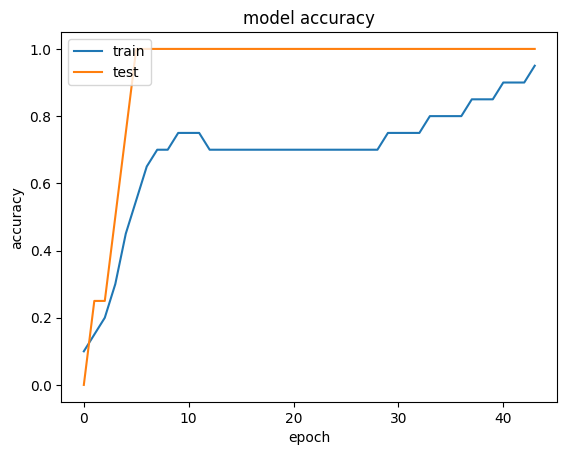

In [17]:
# plot the model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'test'], loc='upper left')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

Text(0.5, 0, 'epoch')

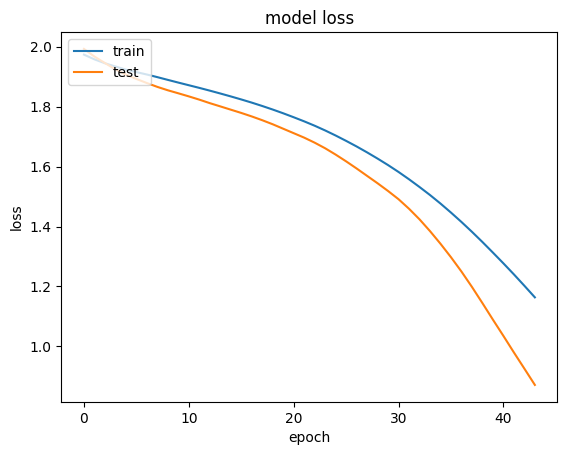

In [18]:
# plot the model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper left')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [37]:
# display processed vectorizerSlekMasuk
dfSeleksiMasukVector = pd.DataFrame(X_train, columns=get_feature_names(vectorizerSlekMasuk))
dfSeleksiMasukVector.index = dfSeleksiMasuk['patterns']
dfSeleksiMasukVector.style.background_gradient(cmap='gray_r')


c:\Users\AndiAlif\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,afirmasi,bersama,jalur,khusus,lainnya,mandiri,nasional,nilai,prestasi,rapor,reguler,sbmptn,seleksi,snmptn,undangan,utbk
patterns,,,,,,,,,,,,,,,,
seleksi nasional,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.751080,0.000000,0.000000,0.000000,0.000000,0.000000,0.660211,0.000000,0.000000,0.000000
snmptn,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
jalur undangan,0.000000,0.000000,0.440977,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.897519,0.000000
jalur prestasi,0.000000,0.000000,0.440977,0.000000,0.000000,0.000000,0.000000,0.000000,0.897519,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
seleksi bersama,0.000000,0.751080,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.660211,0.000000,0.000000,0.000000
sbmptn,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
utbk,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
afirmasi,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
jalur khusus,0.000000,0.000000,0.487908,0.872895,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Training entiti recognition for fakultas

In [38]:
# training model for fakultas
vectorizerFakultas = TfidfVectorizer()
X = vectorizerFakultas.fit_transform(dfFakultas['patterns'].apply(preprocessing_text))
X = X.toarray()
Y = dfFakultas['tag'].values

classCount = len(np.unique(Y))

label_encoderFakultas = LabelEncoder()
integer_encoded = label_encoderFakultas.fit_transform(Y)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
Y = onehot_encoder.fit_transform(integer_encoded)

X_train = X
y_train = Y

take = 0.2
x_test = X_train[:int(len(X_train)*take)]
y_test = y_train[:int(len(y_train)*take)]

modelForFakultas = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(classCount, activation='softmax'),
])

modelForFakultas.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

callbacks = myCallback()

history = modelForFakultas.fit(X_train, y_train,
                        validation_data=(x_test, y_test),epochs=100, callbacks=[callbacks])

Epoch 1/100
2/2 [==============================] - 2s 368ms/step - loss: 2.6386 - accuracy: 0.0417 - val_loss: 2.6672 - val_accuracy: 0.0000e+00
Epoch 2/100
2/2 [==============================] - 0s 33ms/step - loss: 2.6252 - accuracy: 0.1042 - val_loss: 2.6572 - val_accuracy: 0.0000e+00
Epoch 3/100
2/2 [==============================] - 0s 35ms/step - loss: 2.6140 - accuracy: 0.2708 - val_loss: 2.6496 - val_accuracy: 0.0000e+00
Epoch 4/100
2/2 [==============================] - 0s 36ms/step - loss: 2.6020 - accuracy: 0.3958 - val_loss: 2.6425 - val_accuracy: 0.0000e+00
Epoch 5/100
2/2 [==============================] - 0s 35ms/step - loss: 2.5905 - accuracy: 0.4375 - val_loss: 2.6360 - val_accuracy: 0.0000e+00
Epoch 6/100
2/2 [==============================] - 0s 35ms/step - loss: 2.5784 - accuracy: 0.4583 - val_loss: 2.6302 - val_accuracy: 0.1111
Epoch 7/100
2/2 [==============================] - 0s 111ms/step - loss: 2.5644 - accuracy: 0.4583 - val_loss: 2.6244 - val_accuracy: 0.111

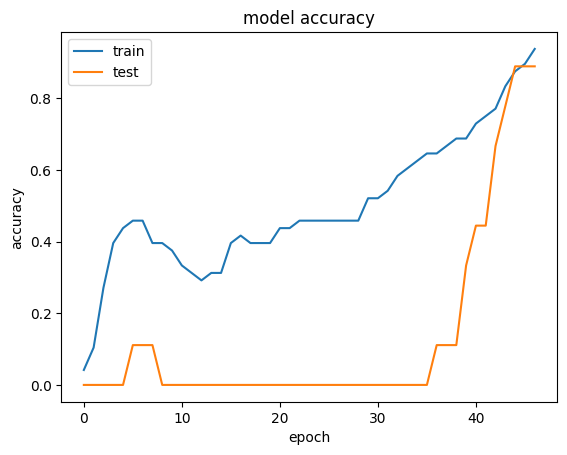

In [39]:
# plot the accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

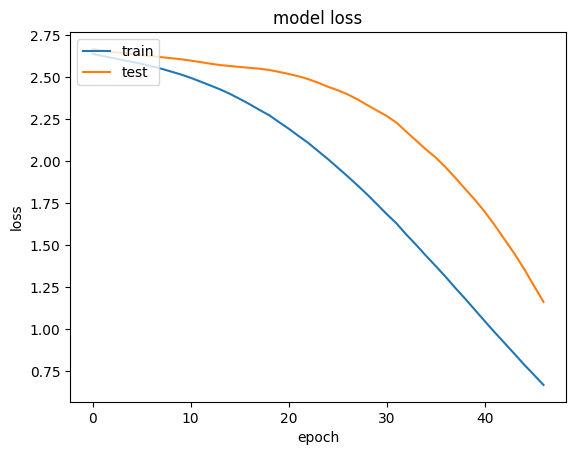

In [40]:
# plot the model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
# display processed vectorizerFakultas
dfFakultasVector = pd.DataFrame(X_train, columns=get_feature_names(vectorizerFakultas))
dfFakultasVector.index = dfFakultas['patterns']
dfFakultasVector.style.background_gradient(cmap='gray_r')

c:\Users\AndiAlif\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,administrasi,admnistrai,bisnis,dan,diploma,ekonomi,fakultas,fapet,feb,fh,fia,filkom,fisip,fk,fkg,fkh,fp,fpik,ft,ftp,gigi,hewan,hukum,ilmu,kedokteran,kelautan,komputer,perikanan,pertanian,peternakan,politik,sosial,teknik,teknologi,vokasi
patterns,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
fakultas ilmu komputer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.435776,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.521244,0.000000,0.000000,0.733760,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
filkom,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ilmu komputer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.579125,0.000000,0.000000,0.815239,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
fakultas ilmu sosial dan ilmu politik,0.000000,0.000000,0.000000,0.375094,0.000000,0.000000,0.272575,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.652069,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.424154,0.424154,0.000000,0.000000,0.000000
fisip,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ilmu sosial dan ilmu politik,0.000000,0.000000,0.000000,0.389856,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.677732,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.440847,0.440847,0.000000,0.000000,0.000000
sosial,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
politik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
fk,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Training entiti recognition for prodi

In [42]:
#training for prodi
vectorizerProdi = TfidfVectorizer()
X = vectorizerProdi.fit_transform(dfProdi['patterns'].apply(preprocessing_text))
X = X.toarray()
Y = dfProdi['tag'].values

classCount = len(np.unique(Y))

label_encoderProdi = LabelEncoder()
integer_encoded = label_encoderProdi.fit_transform(Y)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)

Y = onehot_encoder.fit_transform(integer_encoded)

X_train = X
y_train = Y

take = 0.2

x_test = X_train[:int(len(X_train)*take)]
y_test = y_train[:int(len(y_train)*take)]

modelForProdi = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(classCount, activation='sigmoid'),
])

modelForProdi.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

callbacks = myCallback()

history = modelForProdi.fit(X_train, y_train,
                        validation_data=(x_test, y_test),epochs=150, callbacks=[callbacks])
                        

Epoch 1/150
2/2 [==============================] - 2s 383ms/step - loss: 0.6887 - accuracy: 0.0159 - val_loss: 0.6771 - val_accuracy: 0.0833
Epoch 2/150
2/2 [==============================] - 0s 34ms/step - loss: 0.6722 - accuracy: 0.0476 - val_loss: 0.6612 - val_accuracy: 0.0833
Epoch 3/150
2/2 [==============================] - 0s 35ms/step - loss: 0.6553 - accuracy: 0.0635 - val_loss: 0.6441 - val_accuracy: 0.0833
Epoch 4/150
2/2 [==============================] - 0s 35ms/step - loss: 0.6368 - accuracy: 0.0635 - val_loss: 0.6245 - val_accuracy: 0.0833
Epoch 5/150
2/2 [==============================] - 0s 34ms/step - loss: 0.6158 - accuracy: 0.0635 - val_loss: 0.6022 - val_accuracy: 0.0000e+00
Epoch 6/150
2/2 [==============================] - 0s 34ms/step - loss: 0.5917 - accuracy: 0.0476 - val_loss: 0.5767 - val_accuracy: 0.0000e+00
Epoch 7/150
2/2 [==============================] - 0s 36ms/step - loss: 0.5644 - accuracy: 0.0476 - val_loss: 0.5481 - val_accuracy: 0.0000e+00
Epoch 8

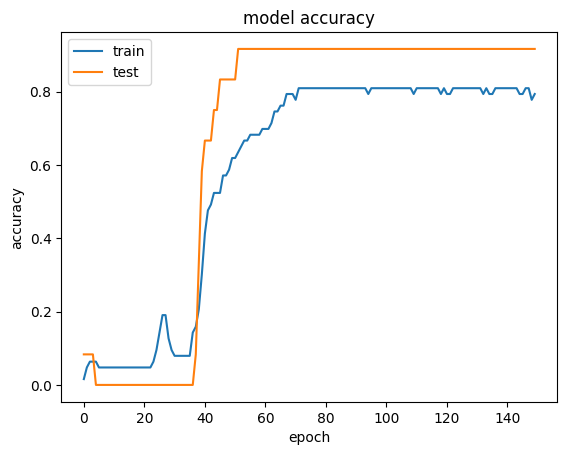

In [43]:
# plot the model akurasi
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'test'], loc='upper left')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()


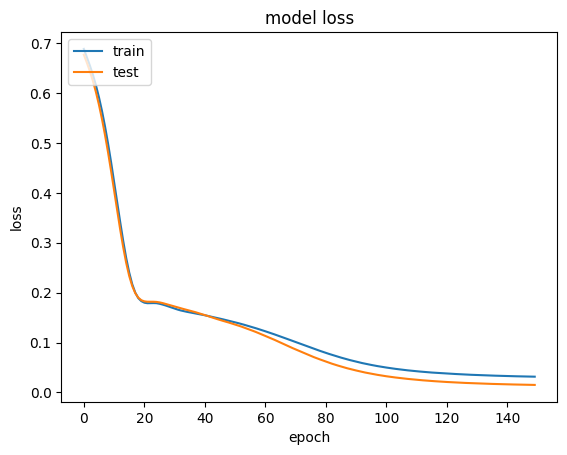

In [44]:
# plot the model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper left')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [49]:
dfProdi['patterns']

0       sistem informasi
1                     si
2     teknik informatika
3                     ti
4        teknik industri
             ...        
58           ilmu ternak
59                    s2
60    doktor ilmu ternak
61           ilmu ternak
62                    s3
Name: patterns, Length: 63, dtype: object

In [50]:
# display processed vectorizerProdi
dfProdiVector = pd.DataFrame(X, columns=get_feature_names(vectorizerProdi))
# dfProdiVector.index = dfProdi['patterns']
dfProdiVector.style.background_gradient(cmap='gray_r')

c:\Users\AndiAlif\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,administrasi,arsitektur,dih,doktor,elektro,fia,fk,geofisika,hukum,ilmu,industri,informasi,informatika,jakarta,kedokteran,kenotariatan,magister,mesin,mih,mkn,negara,niaga,pariwisata,pendidikan,perpajakan,perpustakaan,peternakan,psdku,s1,s2,s3,sarjana,si,sih,sipil,sistem,te,tekdus,teknik,teksip,ternak,ti,tm,ts
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.707107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.707107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.823245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.567686,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.823245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.567686,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.796763,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.604291,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [25]:
def testAllModel(textData):
    print(textData)
    textData = preprocessing_text(textData)

    textDataForSeleksiMasuk = vectorizerSlekMasuk.transform([textData])
    textDataForSeleksiMasuk = textDataForSeleksiMasuk.toarray()

    textDataForFakultas = vectorizerFakultas.transform([textData])
    textDataForFakultas = textDataForFakultas.toarray()

    textDataForProdi = vectorizerProdi.transform([textData])
    textDataForProdi = textDataForProdi.toarray()

    pred = modelForSeleksiMasuk.predict(textDataForSeleksiMasuk)
    pred = np.argmax(pred, axis=1)
    pred = label_encoderSeleksiMasuk.inverse_transform(pred)
    print("seleksi masuk", pred)

    pred = modelForFakultas.predict(textDataForFakultas)
    pred = np.argmax(pred, axis=1)
    pred = label_encoderFakultas.inverse_transform(pred)
    print("fakultas", pred)

    pred = modelForProdi.predict(textDataForProdi)
    pred = np.argmax(pred, axis=1)
    pred = label_encoderProdi.inverse_transform(pred)
    print("prodi", pred)

In [26]:
textData = 'Selamat siang, saya Andi Alifsyah ingin mendaftar di ilmu komputer prodi teknik informatika, saya ingin mengetahui informasi terkait penerimaan mahasiswa baru di Universitas Brawijaya untuk jalur utbk'
testAllModel(textData)

print("---------------")

textData = 'Selamat siang, saya ingin bertanya mengenai daftar ulang bagi mahasiswa kedokteran'
testAllModel(textData)


Selamat siang, saya Andi Alifsyah ingin mendaftar di ilmu komputer prodi teknik informatika, saya ingin mengetahui informasi terkait penerimaan mahasiswa baru di Universitas Brawijaya untuk jalur utbk
1/1 [==============================] - 0s 175ms/step
seleksi masuk ['afirmasi']
1/1 [==============================] - 0s 92ms/step
fakultas ['ft']
1/1 [==============================] - 0s 98ms/step
prodi ['teknik informatika']
---------------
Selamat siang, saya ingin bertanya mengenai daftar ulang bagi mahasiswa kedokteran
1/1 [==============================] - 0s 22ms/step
seleksi masuk ['snmptn']
1/1 [==============================] - 0s 21ms/step
fakultas ['fk']
1/1 [==============================] - 0s 23ms/step
prodi ['kedokteran']
